In [2]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

# Normalization Techniques

Within the literature, the typical approach to oversmoothing is to apply some type of normalization. To this end, we propose orthogonalizing out vector $\vec{q}$ from $X^{l}_{:,i}$ and then renormalizing each column. We incorporate additional scale parameters $0\leq{}s_{1}\leq{}1$ and $s_{2}$, which allow the model to "self-regulate" its own smoothness. 

$$X^{l}_{:,i} = X^{l}_{:,i} - s_{1}\frac{\vec{q}^{T}X^{l}_{:,i}}{||\vec{q}||_{2}^{2}}\vec{q}$$
$$X_{:,i}^{l} = s_{2}\frac{X_{:,i}^{l}}{||X_{:,i}^{l}||_{2}}$$

If $s_{1}=1$ and $\vec{q}=\vec{1}$, this is equivalent to PairNorm with individual scaling [16].

$$X_{:,i}^{l} = X_{:,i}^{l} - \frac{1}{n}\sum_{i=0}^{n}X_{:,i}^{l}$$
$$X_{:,i}^{l} = s \frac{X_{:,i}^{l}}{||X_{:,i}^{l}||_{2}}$$

PairNorm is the current SOTA for GCN normalization/oversmoothing; however, it 1) implicitly assumes that our aggregation step employs the Graph Laplacian or has a similar steady-state and 2) fully orthogonalizes out $\vec{q}$ at each layer, which may be undesirable for learning structure. 

In practice, we find that $\vec{q}$ should approximate the Hadamard inverse of the dominant eigenvector, $v_{1}^{\circ{}-1}$, where $x^{\circ{}-1}\cdot{}x = n$ for $x\in{}R^{n}$. We conduct ablation studies for $\vec{q}=\vec{1}$,$\vec{q} = d_{degree}^{\circ{}-1}$, and $\vec{q}=v_{1}^{\circ{}-1}$ at $l_{max}=64$. Parameters are $s_{1}$ (grad-enabled vs. constant $\sigma{}(1)$) and whether the network possesses 1-hop residual connections, which have been shown to improve the stability and performance of deeper GCNs [15]. The best model is then trained for all $l_{max}=1,2,4,...,64$. We also compare against PairNorm under various settings.

## Dataset

See Section 2.7.2 for description/parameters.

In [3]:
num_graphs = 3000
d = []
for _ in range(num_graphs):
    # Set Cluster sizes and edge probabilities
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    vals = torch.norm(torch.eig(adj.to_dense())[0],dim=1)
    v = 1/(1.01*vals.max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    
    # Set as target
    G.y = y
    G.eig_max = vals.max()
    G.eig_min = vals.min()
    d[idx] = G
    
train,test = d[:2000],d[2000::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

## Model

In [4]:
best_table = []

In [5]:
# Compute the Mean Average Distance of inputs
def batched_MAD(X,edge_index,edge_weights):
    X = X/torch.norm(X,dim=1)[:,None]
    cosine = 1 - torch.sum(X[edge_index[0]] * X[edge_index[1]],dim=1).abs()
    return 1/edge_weights.sum() * (edge_weights * cosine).sum()

# Compute the Aggregation Norm
def batched_agg(X,edge_index,edge_weights,batch):
    nX = torch_scatter.scatter_sum(edge_weights[:,None] * X[edge_index[1]], edge_index[0],dim=0)
    X,nX = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch],\
              nX/torch_scatter.scatter_sum(nX**2,batch,dim=0).sqrt()[batch]
    return torch.norm(X - nX,dim=1).mean()

# Compute normalized (absolute) rayleigh quotient
def rayleigh_quotient(X,edge_index,edge_weights,batch,eig_max,eig_min):
    num = torch_scatter.scatter_sum(X * torch_scatter.scatter_sum(edge_weights[:,None] * 
                                        X[edge_index[1]], edge_index[0],dim=0),
                                        batch, dim=0)
    denom = torch_scatter.scatter_sum(X**2,batch,dim=0)
    R = num/(denom)
    return torch.mean((eig_max[:,None] - R.abs())/(eig_max - eig_min)[:,None])

In [6]:
# Class for the OrthNorm
class OrthNorm(torch.nn.Module):
    def __init__(self,q,grad=True):
        super(OrthNorm,self).__init__()
        self.q = q

        # Scale parameters
        self.s1 = torch.nn.Parameter(torch.ones(1),requires_grad=grad)
        self.s2 = torch.nn.Parameter(torch.ones(1))

    def forward(self,X,edge_index,edge_weight,batch):
        
        # Compute q
        q = self.q(X,edge_index,edge_weight,batch)
        q_norm = torch_scatter.scatter_sum(q**2,batch,dim=0)
        
        # Compute scalar projection of X onto q
        alpha = torch_scatter.scatter_sum(X * q,batch,dim=0)/(q_norm)
        
        # Compute OrthNorm
        X = X - torch.sigmoid(self.s1) * (alpha)[batch] * q
        X = self.s2 * X/(torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt())[batch]
        return X

In [7]:
import torch
import torch_geometric
import torch_sparse
import torch_scatter

# This is a GraphConv model which we can plug various normalization schemes into.
class DummyModel(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,depth,norm,q,grad=True,res=False):
        super(DummyModel,self).__init__()
        self.start = torch.nn.Linear(in_channels,int_channels)
        self.intermediate = torch.nn.ModuleList([torch.nn.ModuleList([torch.nn.Linear(int_channels,int_channels),\
                                                                      torch.nn.Linear(int_channels,int_channels)])\
                                                 for _ in range(depth)])
        self.norm = torch.nn.ModuleList([norm(q,grad) for _ in range(depth)])
        self.finish = torch.nn.Linear(int_channels,out_channels)
        self.res = res

    def forward(self,X,edge_index,edge_weight,batch):
        X = self.start(X)
        for idx,m in enumerate(self.intermediate):
            Update = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)

            if self.res: X = X + Update
            else: X = Update

            X = torch.nn.LeakyReLU()(self.norm[idx](X,edge_index,edge_weight,batch))
            if torch.isnan(X).any(): raise ValueError
        return self.finish(X)

In [8]:
# A helper function to compute various metrics
def get_metrics(model,test_loader,k=64):

  # Layerwise MAD
  model_mad = []
    
  # Layerwise AggNorm
  model_agg = []
    
  # Normalized Rayleigh
  model_ray = []
    
  # S1 parameter
  model_s = []

  MAD,Agg,Ray,S = torch.zeros(k),torch.zeros(k),torch.zeros(k),torch.zeros(k)
    
  # Iterate over dataset and average metrics
  for idx,data in enumerate(test_loader):
        X = data.x.cuda()
        edge_index,edge_weight = data.edge_index.cuda(),data.edge_weight.cuda()
        batch = data.batch.cuda()

        model.eval()
        X = model.start(X)
        
        # Iterate over model layers
        for jdx,m in enumerate(model.intermediate):
            Update = m[0](X) + torch_scatter.scatter_sum(edge_weight[:,None] * m[1](X)[edge_index[1]], edge_index[0],dim=0)

            if model.res: X = X + Update
            else: X = Update
            X = torch.nn.LeakyReLU()(model.norm[idx](X,edge_index,edge_weight,batch))

            # Fetch S1
            S[jdx] += torch.sigmoid(model.norm[jdx].s1).item()
            
            # Compute MAD
            MAD[jdx] += batched_MAD(X,data.edge_index.cuda(),data.edge_weight.cuda()).mean().item()
            
            # Compute AggNorm
            Agg[jdx] += batched_agg(X,data.edge_index.cuda(),data.edge_weight.cuda(),batch).item()
            
            #Compute Normalized Rayleigh
            Ray[jdx] += rayleigh_quotient(X,edge_index,edge_weight,batch,data.eig_max.cuda(),data.eig_min.cuda()).mean().item()
        
  model_mad.append(MAD/(idx+1))
  model_agg.append(Agg/(idx+1))
  model_ray.append(Ray/(idx+1))
  model_s.append(S/(idx+1))

  # Return metrics
  return (model_mad,model_agg,model_ray,model_s)

## OrthNorm

### $\vec{q} = \vec{1}$

In [9]:
# Compute ones vector
def identity(X,edge_index,edge_weight,batch):
    return torch.ones(X.shape[0]).cuda()[batch,None]

In [10]:
graph_results = []
metrics = []

### Non-residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,identity).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,identity,res=True).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,identity,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,identity,res=True,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

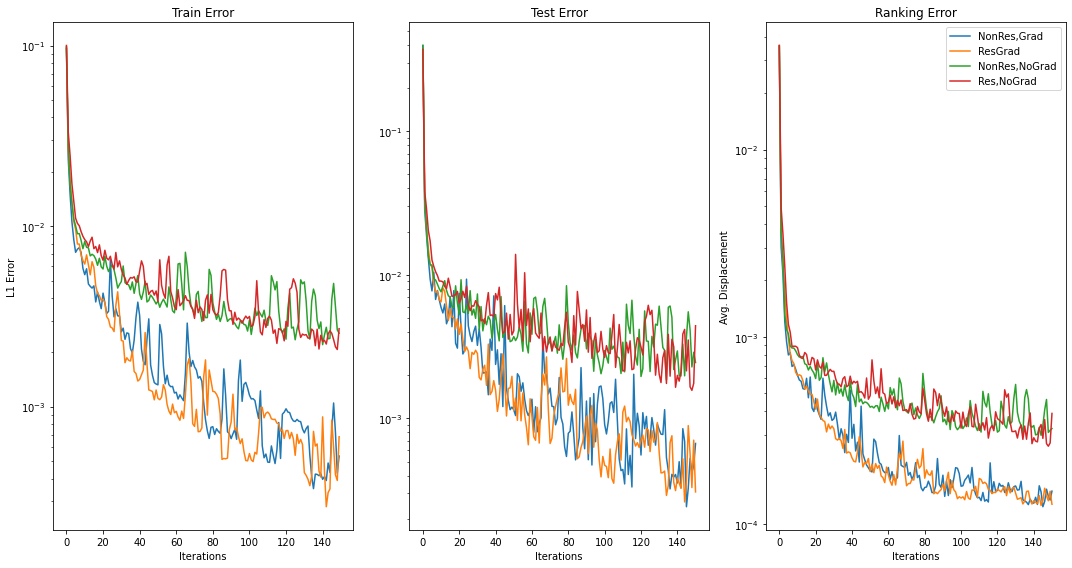

In [11]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(4):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(4):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. The defining factor appears to be whether $s_{1}$ is a trainable parameter; fixing it increases the L1 error by around an order of magnitude. Adding residual connections does not noticably impact performance. Regardless, we see significant improvement from the earlier $l=64$ model with batch normalization (see 4.1).

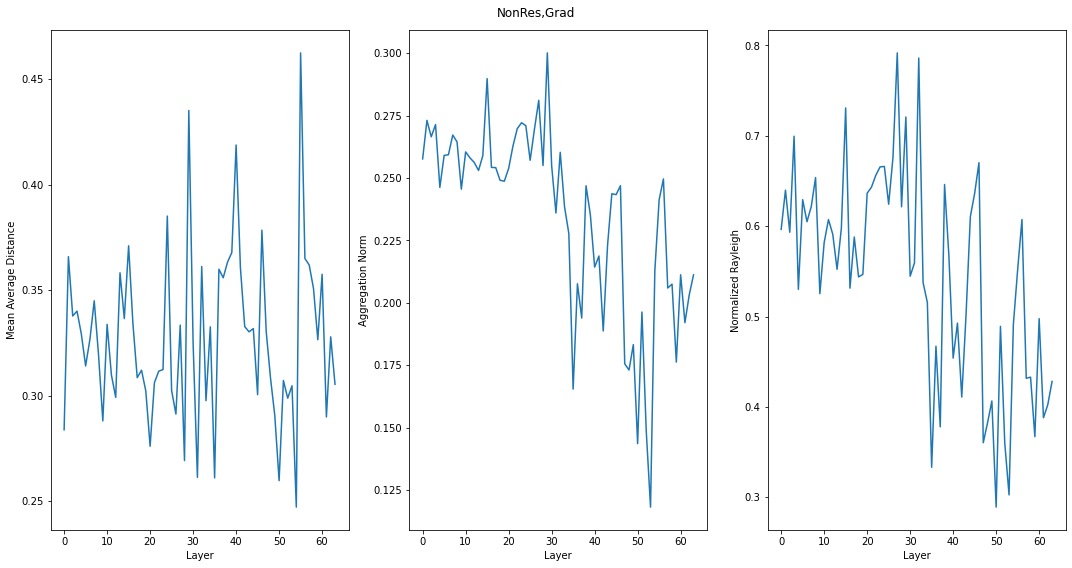

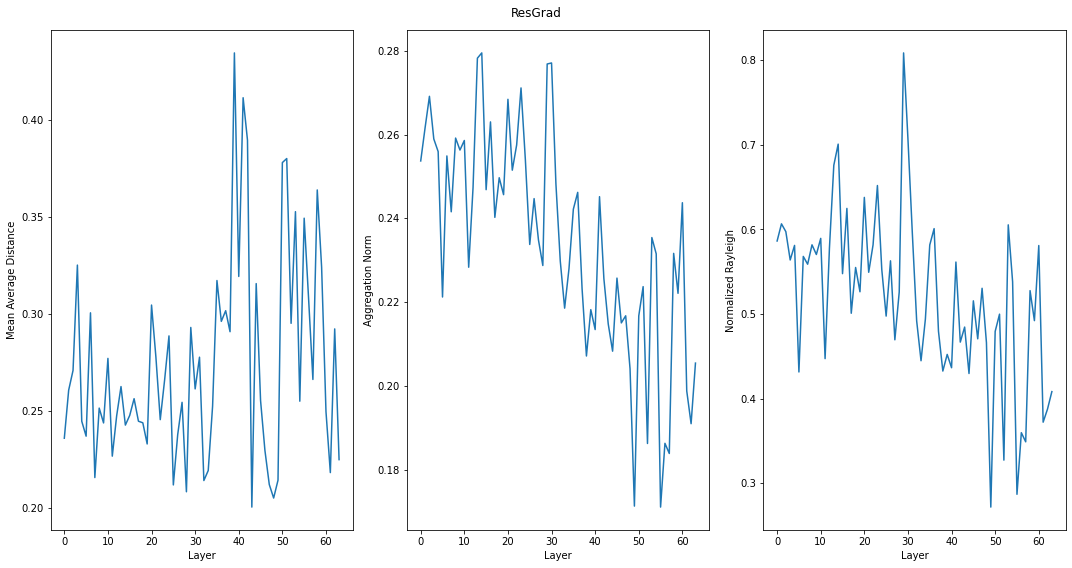

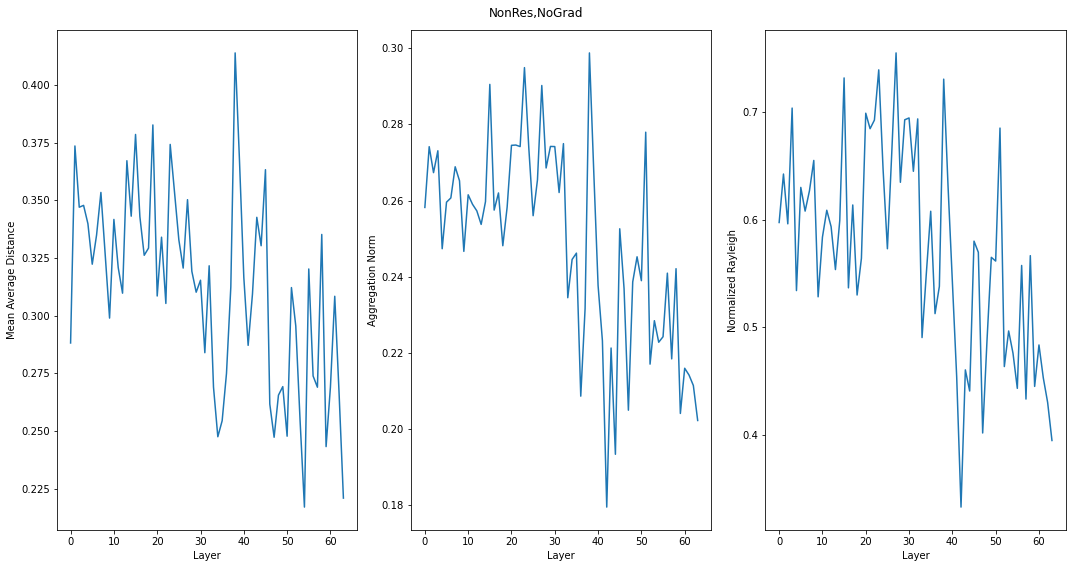

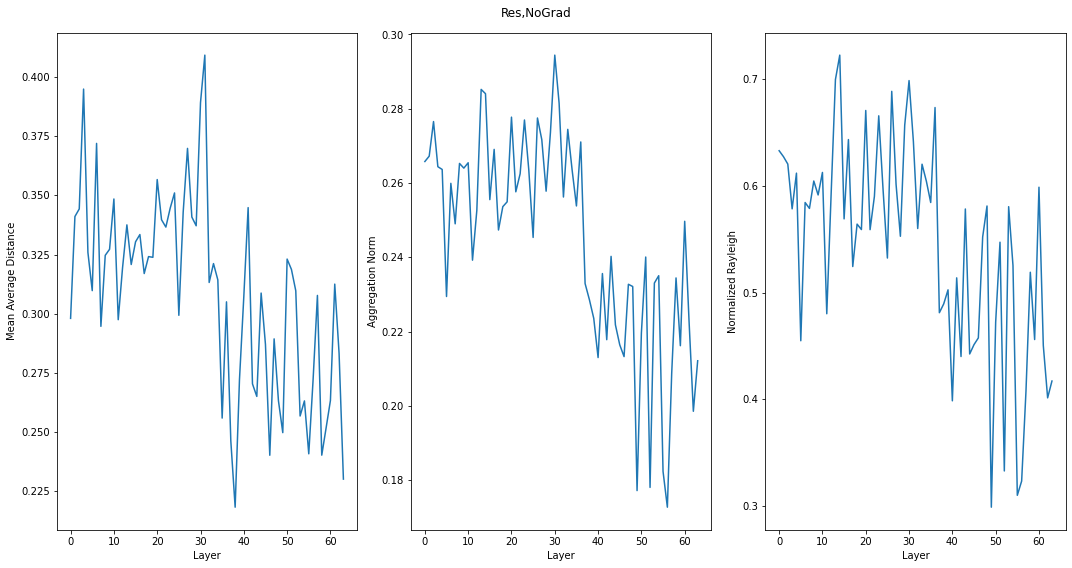

In [12]:
for idx,l in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  plt.plot(metrics[idx][0][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx][1][0])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx][2][0])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh')

  plt.suptitle(l)
  plt.tight_layout()
  plt.show()

We observe two regimes throughout the model layers; when $l<32$, AggNorm and Rayleigh are relatively large, but, once $l\geq{}32$, the mean values drop sharply. Below we plot the trained values of $s_{1}$ vs. $l$ and see a similar pattern. $s_{1}$ mostly oscillates between $.6$ and $.8$ for the first half of the model and then decays to $0.0$ in the final few layers. 

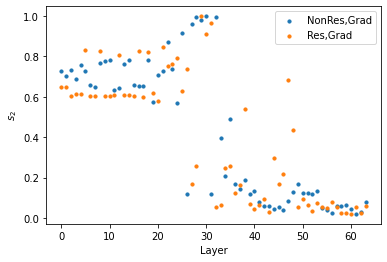

In [13]:
plt.scatter(range(64),(metrics[0][-1][0]),label='NonRes,Grad',s=10)
plt.scatter(range(64),(metrics[1][-1][0]),label='Res,Grad',s=10)
plt.legend()
plt.ylabel('$s_{2}$')
plt.xlabel('Layer');

In [13]:
best_table.append([np.min(graph_results[i][1]) for i in range(4)])

### $q = d_{degree}^{\circ{}-1}$

In [18]:
# Compute Hadamard Inverse of degree
def inverse_degree(X,edge_index,edge_weight,batch):
    degree = torch_geometric.utils.degree(edge_index[0]).cuda()[:,None]
    degree = degree/torch_scatter.scatter_sum(degree**2,batch,dim=0)[batch]
    return 1/degree

In [19]:
graph_results = []
metrics = []

### Non-residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_degree).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_degree,res=True).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_degree,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_degree,res=True,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

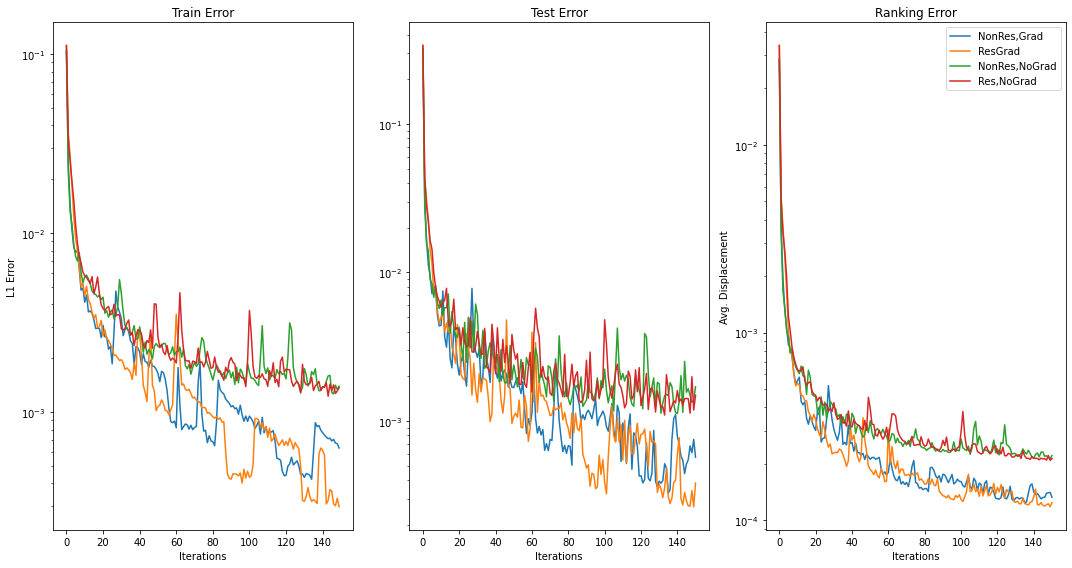

In [20]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(4):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(4):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. Like with $\vec{q}=\vec{1}$, the greatest boost in performance comes from training with regards to $s_{1}$. We observe slightly better losses when the gradient is disabled, and adding residual connections offers further improvement in the gradient-enabled case. 

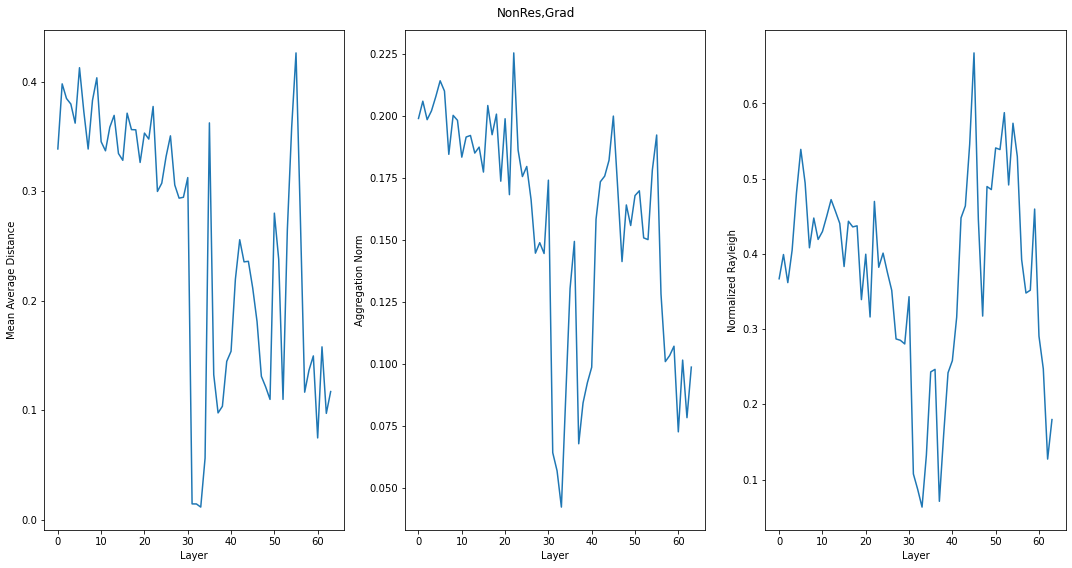

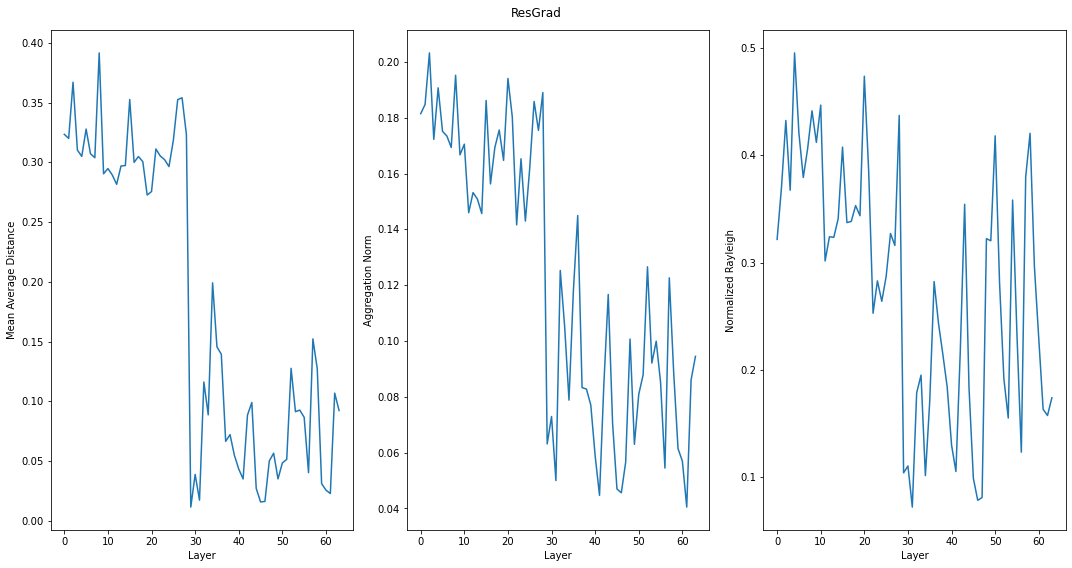

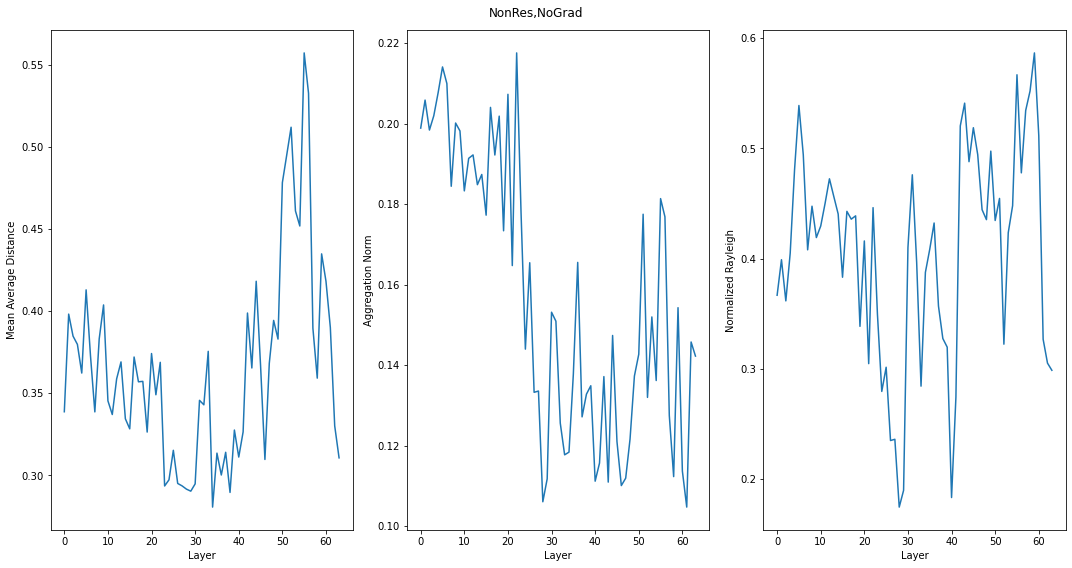

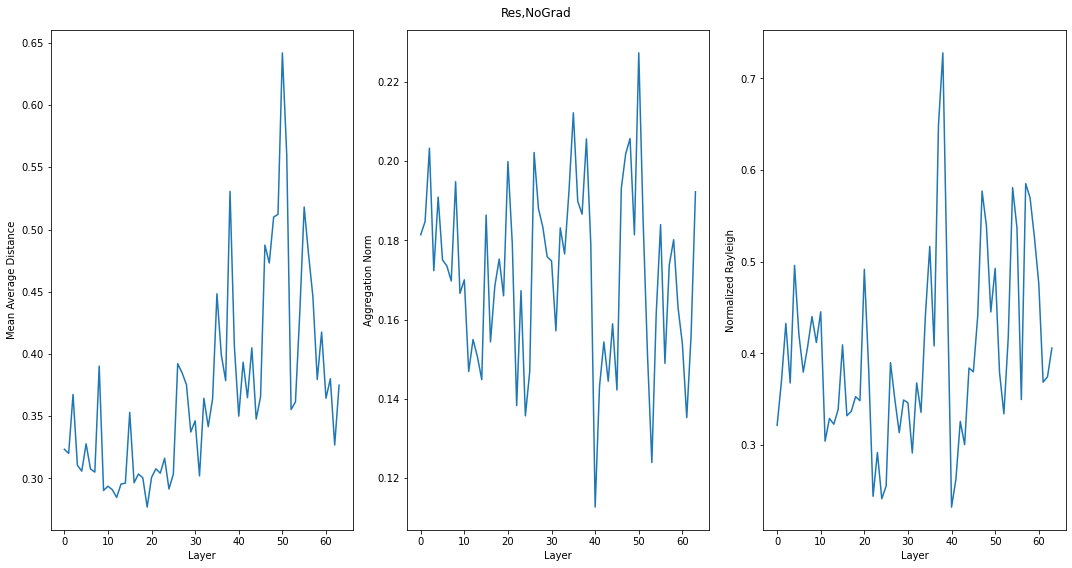

In [21]:
for idx,l in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  plt.plot(metrics[idx][0][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx][1][0])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx][2][0])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh')

  plt.suptitle(l)
  plt.tight_layout()
  plt.show()

There is still a defined jump in our metrics for the ResGrad model, whereas NonResGrad is more variable than before. Indeed, in the below figure, we see the $s_{1}$ values of the latter randomly spike during the $l\geq{}32$ regime.

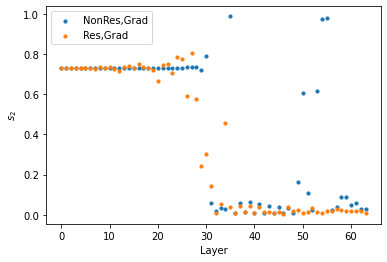

In [22]:
plt.scatter(range(64),(metrics[0][-1][0]),label='NonRes,Grad',s=10)
plt.scatter(range(64),(metrics[1][-1][0]),label='Res,Grad',s=10)
plt.legend()
plt.ylabel('$s_{2}$')
plt.xlabel('Layer');

In [23]:
best_table.append([np.min(graph_results[i][1]) for i in range(4)])

### $q=v_{1}^{\circ{}-1}$

In [24]:
# Compute the Hadamard inverse of the approximate dominant eigenvector
def inverse_eig(X,edge_index,edge_weight,batch):
    with torch.no_grad():
        Z = torch.ones((X.shape[0],1)).cuda()
        for _ in range(20):
            Z = torch_scatter.scatter_sum(edge_weight[:,None] * Z[edge_index[1]], edge_index[0],dim=0)/10
        Z = Z/torch_scatter.scatter_sum(Z**2,batch,dim=0).sqrt()[batch]
        return 1/(1e-4 + Z)

In [25]:
graph_results = []
metrics = []

### Non-residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_eig).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, grad-enabled
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_eig,res=True).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_eig,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual, no grad
torch.manual_seed(0)
model = DummyModel(1,32,1,64,OrthNorm,inverse_eig,res=True,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

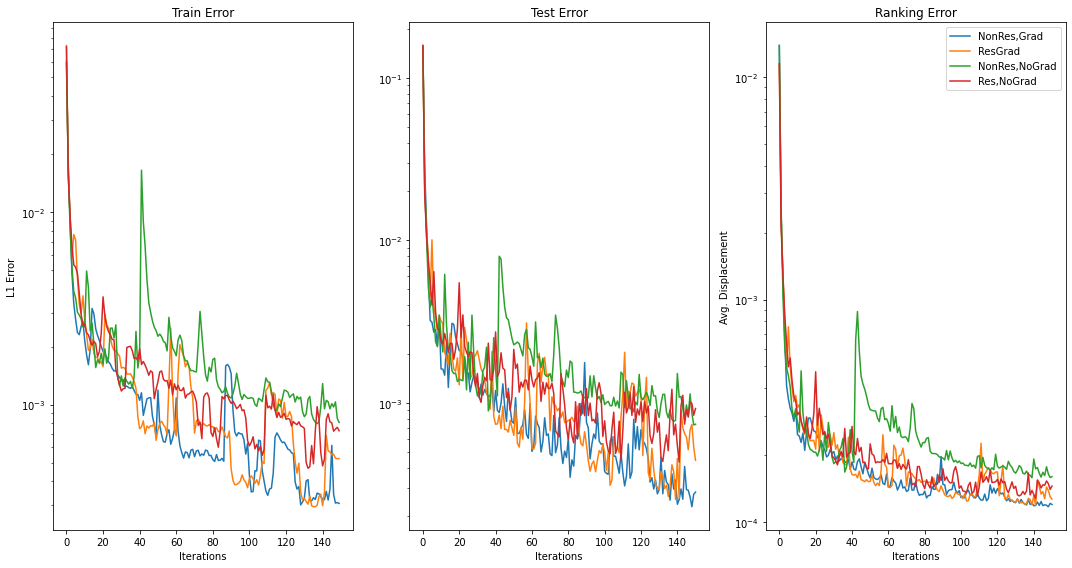

In [26]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(4):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(4):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. Performance is further improved for gradient-disabled models, particularily when residual connections are also incorporated. NonRes,Gred converges to the lowest test loss.

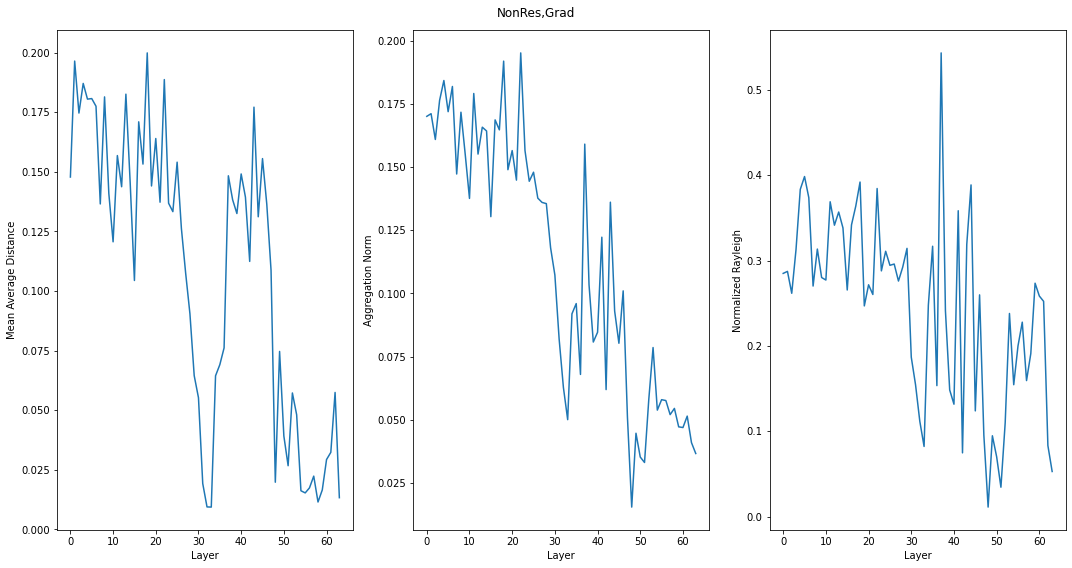

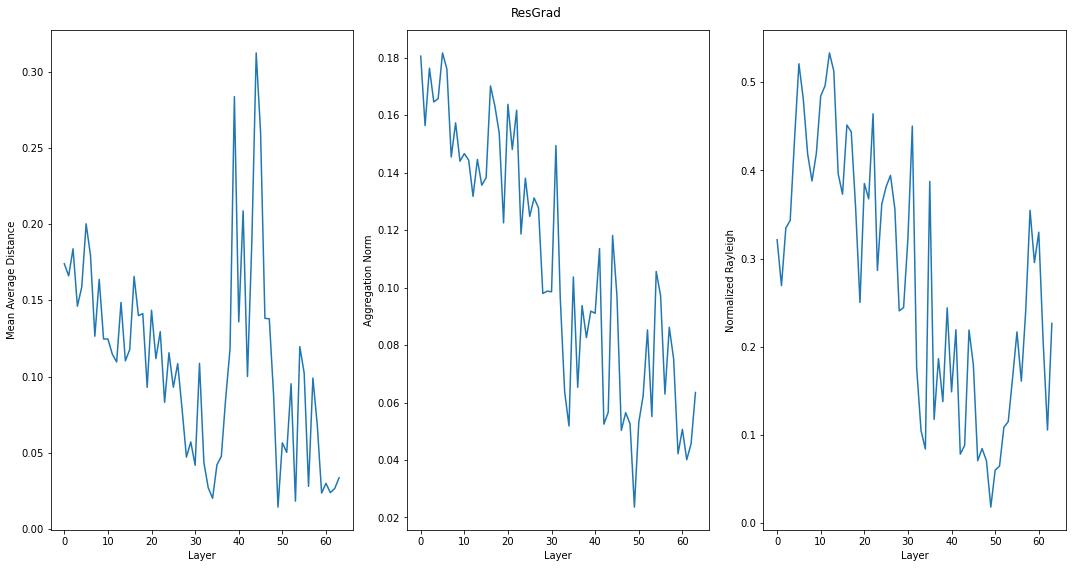

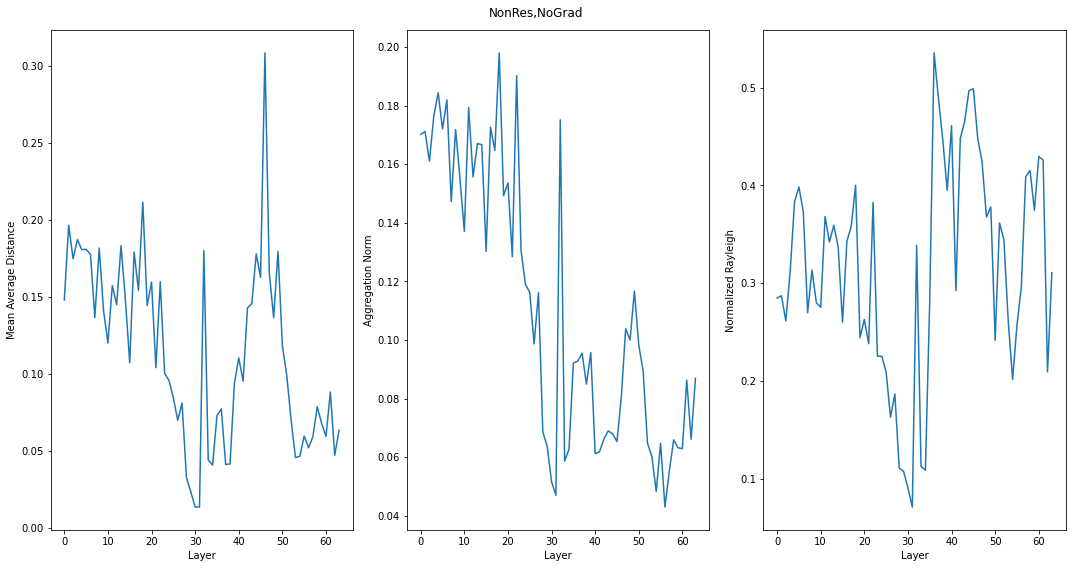

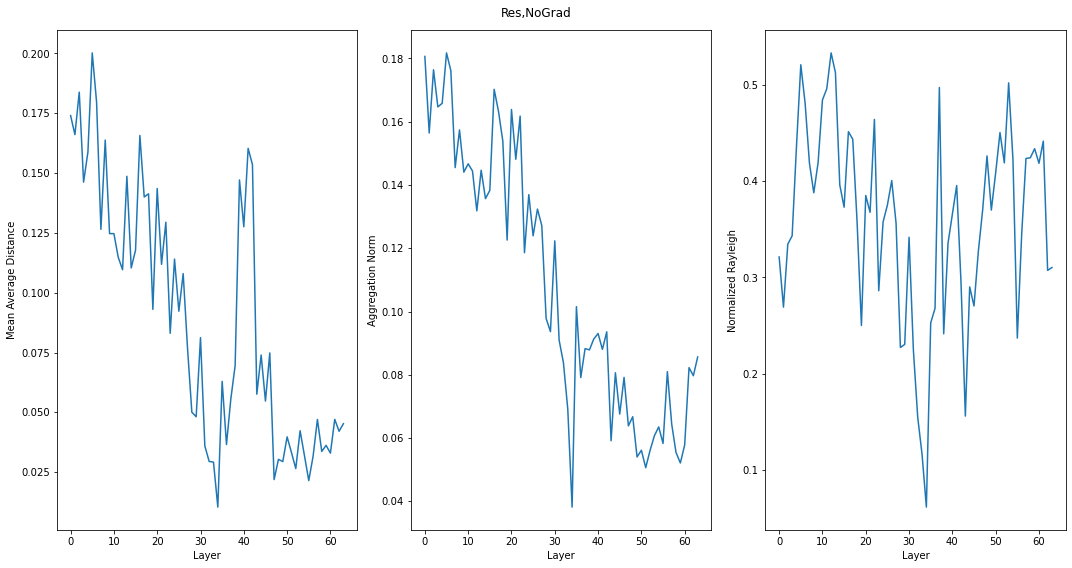

In [27]:
for idx,l in enumerate(['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']):
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  plt.plot(metrics[idx][0][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx][1][0])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx][2][0])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh')

  plt.suptitle(l)
  plt.tight_layout()
  plt.show()

Difference between regimes is less apparent, as our metrics are prone to large spikes shortly after $l=32$. AggNorm is the most informative of the three; it steadily declines, and, when ranked, its final values roughly correspond to the ordering of the models with regards to test loss. We still observe a clear partition in the $s_{1}$ (see below).

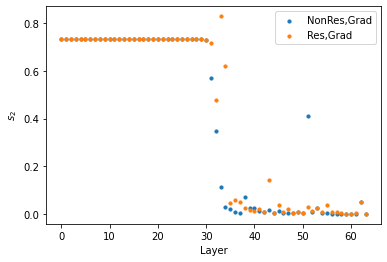

In [28]:
plt.scatter(range(64),(metrics[0][-1][0]),label='NonRes,Grad',s=10)
plt.scatter(range(64),(metrics[1][-1][0]),label='Res,Grad',s=10)
plt.legend()
plt.ylabel('$s_{2}$')
plt.xlabel('Layer');

In [29]:
best_table.append([np.min(graph_results[i][1]) for i in range(4)])

### Best Model

In [30]:
import pandas as pd

table = pd.DataFrame(best_table)
table.columns = ['NonRes,Grad','ResGrad','NonRes,NoGrad','Res,NoGrad']
table.index = ['Ones','InverseDegree','InverseEig']
table

,"NonRes,Grad",ResGrad,"NonRes,NoGrad","Res,NoGrad"
Ones,0.000240,0.000293,0.002130,0.001970
InverseDegree,0.000326,0.000264,0.001121,0.001095
InverseEig,0.000229,0.000255,0.000732,0.000432


Across the board, the best results are obtained for $\vec{q}=v_{1}^{\circ{}-1}$. We do not currently have a theoretical explanation for this, and indeed it seems somewhat counterintuitive. Difference between choices of $\vec{q}$ is minimal when $s_{1}$ is gradient-enabled, but otherwise $v_{1}^{\circ{}-1}$ offers noticably better performance. We find limited benefit to residual connections. Below, we train the NonRes,Grad model for all $l=1,2,4,...,64$ using the inverse approximate $v_{1}$.

In [31]:
graph_results = []
metrics = []

for k in [1,2,4,8,16,32,64]:
    torch.manual_seed(0)
    model = DummyModel(1,32,1,k,OrthNorm,inverse_eig,res=True).cuda()

    graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
    metrics.append(get_metrics(model,test_loader,k))

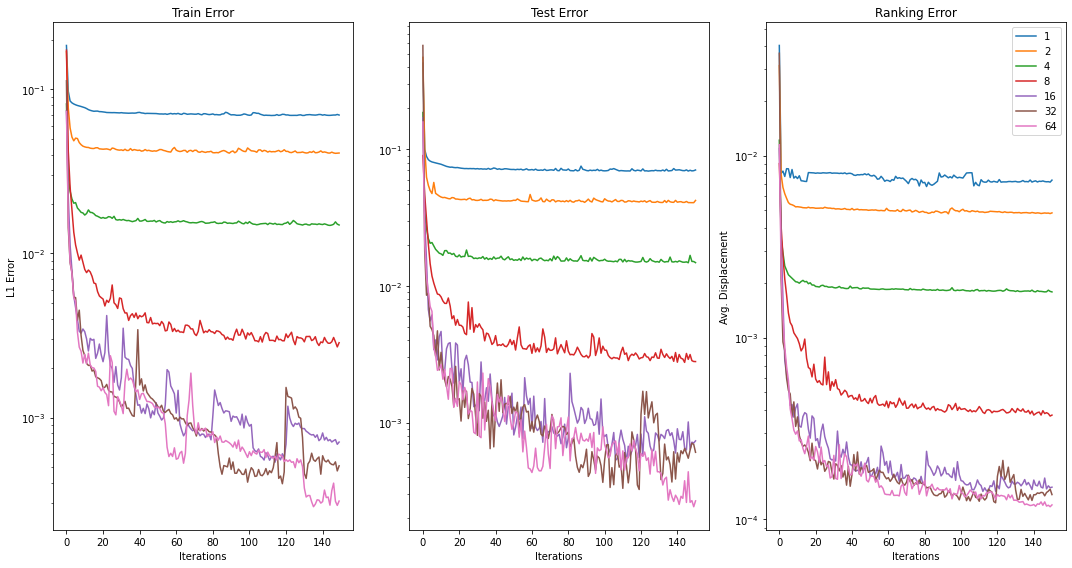

In [32]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(7):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(7):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate([1,2,4,8,16,32,64]):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. All models for $l_{max}\geq{}8$ are improved versus the batch normalization case in 4.1

## PairNorm

We assess PairNorm (see 5.1) with both individual and global scaling, as well as residual connections. [15] find that GCNConv and GATConv perform better with individual scaling, but this was on datasets (the "holy trinity" of graph learning: Cora, Citeseer, and PubMed) with limited structural class dependence. Global scaling is given by:

$$X_{:,i}^{l} = s \frac{X_{:,i}^{l}}{\sqrt{\frac{1}{n}\sum_{j=0}^{n}||X_{:,j}^{l}||_{2}^{2}}}$$

In [42]:
# PairNorm implementation
class PairNorm(torch.nn.Module):
    def __init__(self,q=None,grad=True):
        super(PairNorm,self).__init__()
        self.norm = torch_geometric.nn.PairNorm(scale_individually=grad)
        self.s1 = torch.ones(1)
    def forward(self,X,edge_index,edge_weight,batch):
        return self.norm(X,batch)

In [44]:
graph_results = []
metrics = []

### Non-residual, scale-individually
torch.manual_seed(0)
model = DummyModel(1,32,1,64,PairNorm,None).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

### Residual, scale-individually
torch.manual_seed(0)
model = DummyModel(1,32,1,64,PairNorm,None,res=True).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Non-residual
torch.manual_seed(0)
model = DummyModel(1,32,1,64,PairNorm,None,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

# Residual
torch.manual_seed(0)
model = DummyModel(1,32,1,64,PairNorm,None,res=True,grad=False).cuda()

graph_results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
metrics.append(get_metrics(model,test_loader))
torch.cuda.empty_cache()

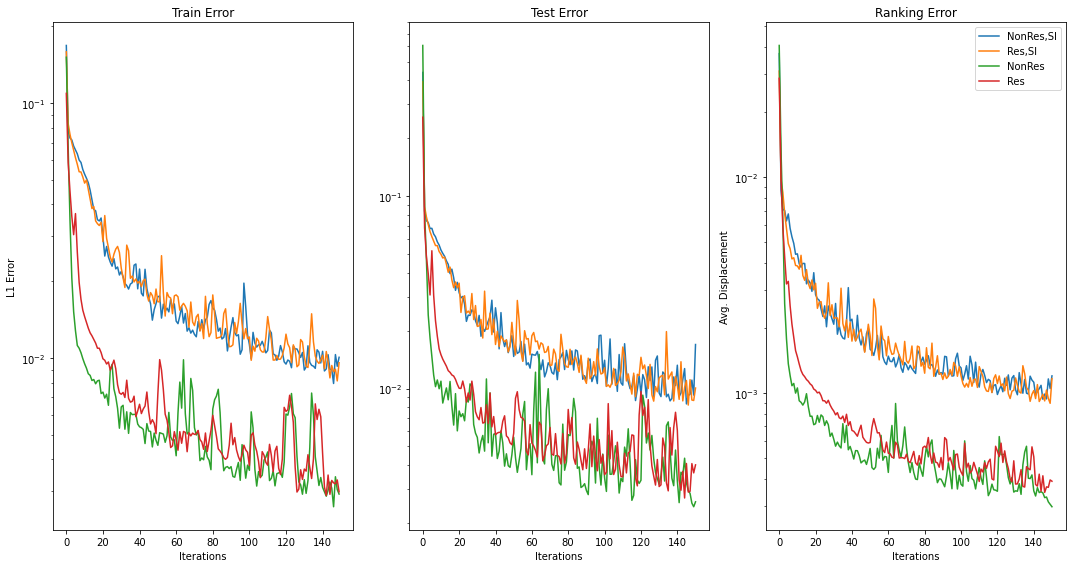

In [45]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for i in range(4):
  plt.semilogy(graph_results[i][0])

plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for i in range(4):
  plt.semilogy(graph_results[i][1])

plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,alpha in enumerate(['NonRes,SI','Res,SI','NonRes','Res']):
  plt.semilogy(graph_results[idx][2],label=alpha)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

We plot a) training loss b) test loss and c) average rank displacement. Individual scaling (or PairNorm-SI, as it is refered to in [15]) performs worse than global scaling, which is itself only comparable to OrthNorm with constant $s_{1}$. Residual connections offer no pronounced improvement. 

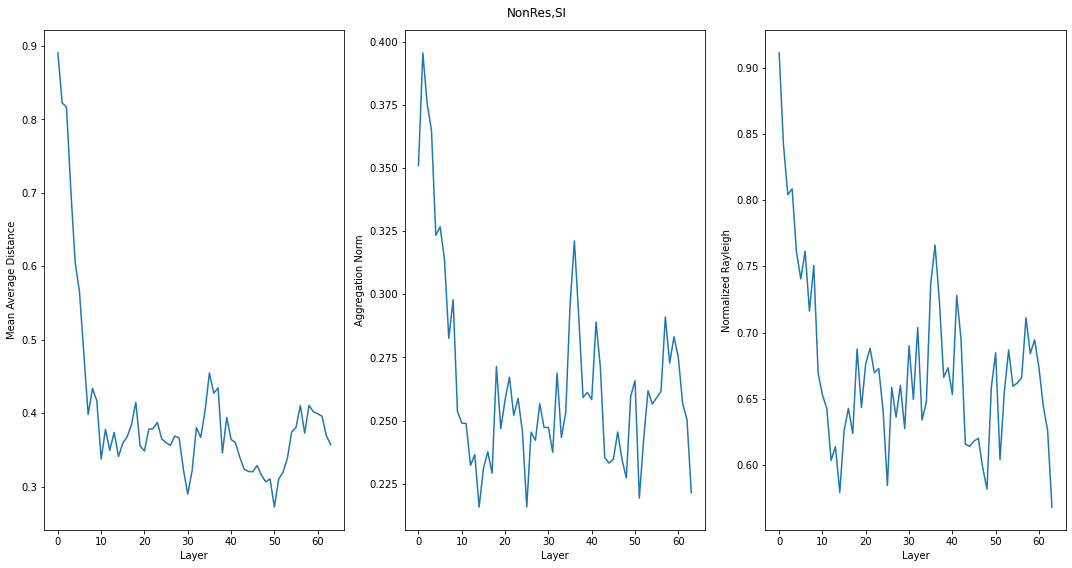

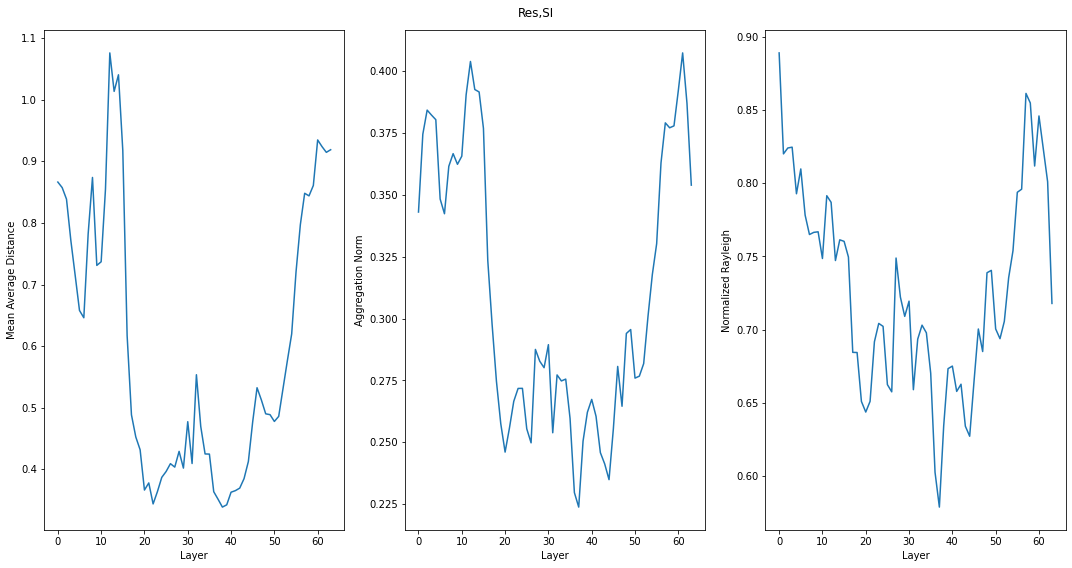

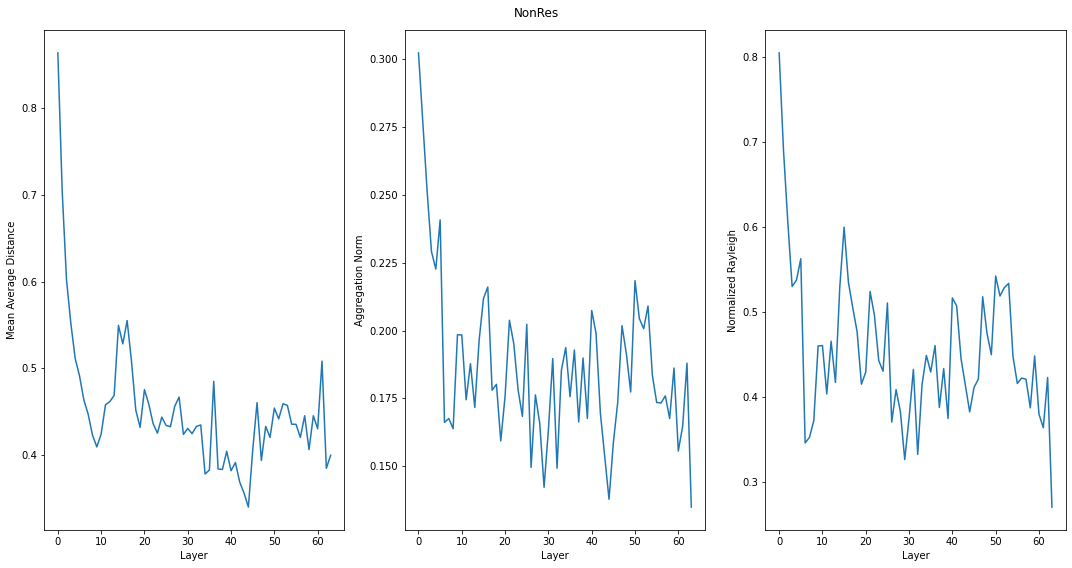

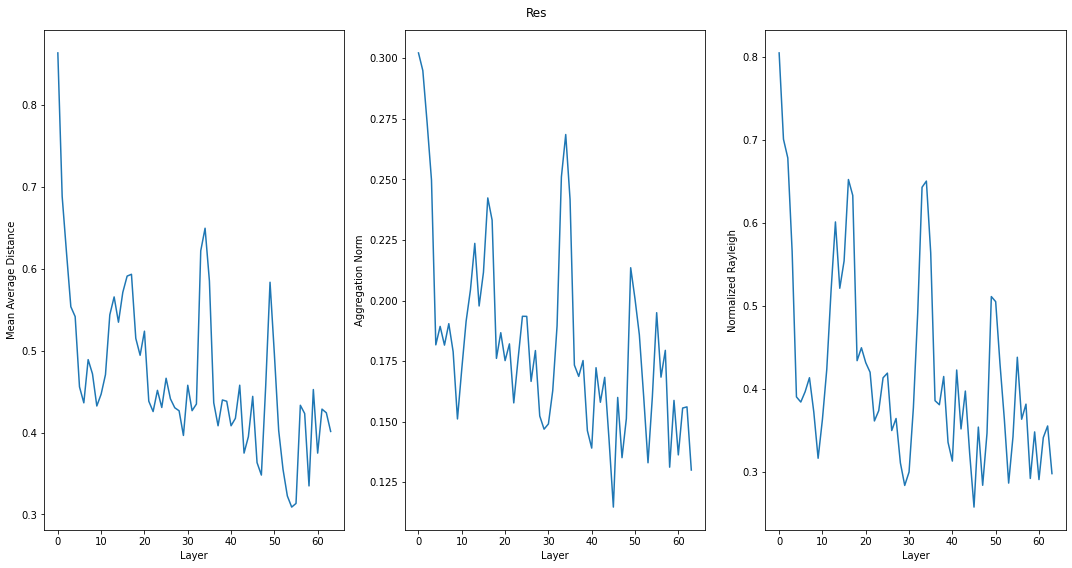

In [46]:
for idx,l in enumerate(['NonRes,SI','Res,SI','NonRes','Res']):
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  plt.plot(metrics[idx][0][0],label='MAD')
  plt.xlabel('Layer')
  plt.ylabel('Mean Average Distance')

  plt.subplot(1,3,2)
  plt.plot(metrics[idx][1][0])
  plt.xlabel('Layer')
  plt.ylabel('Aggregation Norm')

  plt.subplot(1,3,3)
  plt.plot(metrics[idx][2][0])
  plt.xlabel('Layer')
  plt.ylabel('Normalized Rayleigh')

  plt.suptitle(l)
  plt.tight_layout()
  plt.show()

Outside of the ResSI model, our metrics looks quite similar to the BatchNorm case (see 4.1) with large starting values and a gradual decay. Final values are close to those of OrthNorm when $\vec{q}=\vec{1}$, which makes sense due to their similarity. 

## Overview

Our new normalization scheme, which we are calling OrthNorm (i.e Orthagonal Normalization, get it?), improves upon the BatchNorm case. It surpasses PairNorm by around an order of magnitude given the same depth and number of epochs. We suspect this is because $d_{Katz}$ is close enough to $v_{1}$, and so PairNorm reduces the feature smoothness *too* much. Indeed, PairNorm returns larger MAP, AggNorm, and normalized Rayleigh for each layer, whereas those of OrthNorm are generally smaller and more variable. This is due to $s_{1}$ regulating the degree of orthogonalization; indeed, fixing $s_{1}$ noticably hampers performance.